In [1]:
import sys, os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import Planck15

from units import *
from lensing_sim import LensingSim
from scipy.integrate import quad

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Fixed parameters

In [2]:
# Grid size
n_x, n_y = 52, 52
x_lims, y_lims = [-2, 2], [-2, 2]

# Host halo parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.01, 'theta_y':-0.01, 'theta_E':1.}

# Observational parameters
observation_dict = {'nx':n_x, 'ny':n_y, 'xlims':x_lims, 'ylims':y_lims, 'exposure':(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2}
global_dict = {'z_s':1.0, 'z_l':0.1}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

## Mass function parameters

In [3]:
def dndm(m, beta=-1.9,alpha=2e8/M_s):
    return alpha*(m/M_s)**beta

In [7]:
mmin = 1e7*M_s
mmax = 1e10*M_s

# Mean number of subhalos
nu_sh = quad(lambda m: dndm(m), mmin, mmax)[0]

print(nu_sh)

111.15271858383846


In [8]:
# "z" parameters
n = np.random.poisson(nu_sh) # Number of subhalos
x_coords = np.random.uniform(low=x_lims[0], high=x_lims[1], size=n) # Subhalo coordinates
y_coords = np.random.uniform(low=y_lims[0], high=y_lims[1], size=n)

print(n)

105


## Generate image

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


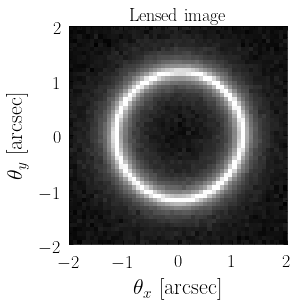

In [9]:
lens_list = [hst_param_dict]

# Substructure parameters
for isub in range(n):
    sub_param_dict = {'profile':'nfw', 'theta_x':x_coords[isub], 'theta_y':y_coords[isub], 'M200': 10**9*M_s}
#     sub_param_dict = {'profile':'sis', 'theta_x':x_coords[isub], 'theta_y':y_coords[isub], 'theta_E':0.1}
    lens_list.append(sub_param_dict)

# Generate lensed image
LSI = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
i_tot = np.random.poisson((LSI.lensed_image()))

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims, origin="lower")
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');